In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pickle
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import time

path = "C:/Users/madsl/Dropbox/EIT 7.sem/P7/Python6_stuff/MachineLearning/"
print(path)

PLOT_TRAIN = True
PLOT_TEST = True
PLOT_TEST_LOSS = True
MAX_LAYERS = 4

C:/Users/madsl/Dropbox/EIT 7.sem/P7/Python6_stuff/MachineLearning/


In [2]:
def reset_dirs():
    #current_time = time.strftime("%m%d-%H")  # get the current time
    for layer in range(MAX_LAYERS):
        shutil.rmtree(f'{path}data/DNN_results/sigmoid/train_loss/MADStrain_loss_layer{layer+1}', ignore_errors=True)
        shutil.rmtree(f'{path}data/DNN_results/sigmoid/test_pred/MADStest_pred_layer{layer+1}', ignore_errors=True)
        #shutil.rmtree(f'{path}data/DNN_results/sigmoid/test_loss/MADStest_loss_layer{layer+1}', ignore_errors=True)
        
        os.makedirs(f'{path}data/DNN_results/sigmoid/train_loss/MADStrain_loss_layer{layer+1}')
        os.makedirs(f'{path}data/DNN_results/sigmoid/test_pred/MADStest_pred_layer{layer+1}')
        #os.makedirs(f'{path}data/DNN_results/sigmoid/test_loss/MADStest_loss_layer{layer+1}')
        
    shutil.rmtree(f'{path}data/DNN_results/sigmoid/Models', ignore_errors=True)
    os.mkdir(f'{path}data/DNN_results/sigmoid/Models')
    return

In [3]:
def load_data(path: str):
    """
    This function loads data from a pickle file located at the provided path.

    Parameters:
        path (str): The path to the pickle file.

    Returns:
        par_comb (np.ndarray): The parameter combinations.
        S11_par (np.ndarray): The best parametric data.
        frequency (np.ndarray): The frequency data.
        degrees (np.ndarray): The degrees data.
        combined_gain (np.ndarray): The combined gain list.
        std_dev (np.ndarray): The standard deviation of Phi.
        efficiency (np.ndarray): The efficiency data.
    """

    with open(path,'rb') as file:
        data_dict = pickle.load(file)
    print(f"Dictionary keys: {data_dict.keys()}")

    par_comb = np.asarray(data_dict['Parameter combination'])
    S11_vals = np.asarray(data_dict['S1,1'])
    frequency = np.asarray(data_dict['Frequency'])
    S11_parametrized = np.asarray(data_dict['Parametric S1,1'])
    degrees = np.asarray(data_dict['degrees'])
    combined_gain = np.asarray(data_dict['combined gain list'])
    std_dev = np.asarray(data_dict['Standard deviation Phi'])
    efficiency = np.asarray(data_dict['efficiency'])
    return par_comb, S11_vals, S11_parametrized, frequency, degrees, combined_gain, std_dev, efficiency

def normalize_data(data, inverse: bool):
    if inverse:
        data_norm = data*np.std(data) + np.mean(data)
    else:   
        mean = np.mean(data)
        std = np.std(data)
        data_norm = (data-mean)/std
    return data_norm

def rational_func(x, *args):
    global Number_of_poles

    def rational(data, p, q):
        return np.polyval(q, data) / np.polyval(p + [1.0], data)

    # Split the args into poles and zeros
    poles = args[:Number_of_poles]
    zeros = args[Number_of_poles:]
    #print(poles, zeros)  # Debugging line
    return rational(x, [*poles], [*zeros])



Dictionary keys: dict_keys(['Parameter combination', 'S1,1', 'Frequency', 'degrees', 'combined gain list', 'Standard deviation Phi', 'efficiency', 'Parametric S1,1'])


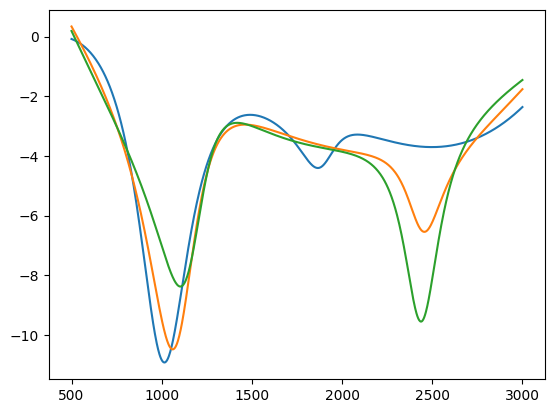

In [4]:
par_comb, S11_vals, S11_parameterized, frequency, degrees, combined_gain, std_dev, efficiency = load_data("data/simple_wire2_final_with_parametric.pkl")

random_indices = random.sample(range(0, S11_parameterized.shape[0]), 10)


for index, run in enumerate([2000, 2010, 2020]):
    poles = S11_parameterized[run][0,:]
    Number_of_poles = len(poles[poles != 0])

    pole_zero_flat = np.asarray(S11_parameterized[run]).flatten()
    pole_zero_flat = pole_zero_flat[pole_zero_flat != 0]
    
    plt.plot(frequency, rational_func(frequency, *pole_zero_flat), label="Fitted")
plt.show()



s11_parameterized_flat = [np.reshape(arr, -1) for arr in S11_parameterized]

# Normalize the input data to the model
par_comb_norm = normalize_data(par_comb, inverse=False)
combined_gain_norm = normalize_data(combined_gain, inverse=False)
std_dev_norm = normalize_data(std_dev, inverse=False)
efficiency_norm = normalize_data(efficiency, inverse=False)
S11_vals_norm = normalize_data(S11_vals, inverse=False)
s11_parameterized_flat_norm = normalize_data(s11_parameterized_flat, inverse=False)
# print(s11_parameterized_flat_norm[1])
# print(s11_parameterized_flat_norm.shape)
input_vector = par_comb_norm

output_vector = np.asarray([np.concatenate((s11_parameterized_flat[i], [std_dev[i]], [efficiency[i]]))for i in range(S11_vals.shape[0])])

# output_vector = normalize_data(output_vector, inverse=False)

x_train, x_test, y_train, y_test = train_test_split(input_vector, output_vector, test_size=0.3, shuffle=True, random_state=42)

In [5]:
base_layers = [
    layers.InputLayer(input_shape=input_vector.shape[1], name = 'Input_layer'),
    layers.Dense(128, activation = 'sigmoid', name = 'layer_1'),
    layers.Dense(128, activation = 'sigmoid', name = 'layer_2'),
    layers.Dense(y_train.shape[1], activation = 'linear', name = 'Output_layer')
]


In [6]:
reset_dirs()

In [7]:

for layer in range(2,MAX_LAYERS):
    start_time = time.perf_counter()
    # Add a layer to the model
    base_layers.insert(-1, layers.Dense(128, activation='sigmoid', name = f'layer{layer+1}'))
    
    # Create the model
    model = keras.Sequential(base_layers,name=f'Sequential_{layer+1}')
    model.summary()

    # Compile the model with the solver adam and the loss function MSE
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.MeanAbsoluteError(),
        metrics=[keras.metrics.MeanSquaredError()]
    )

    # Create lists to store the results
    loss_train = []
    mean_error_train = []
    mean_error_pred = np.zeros(50)
    # Train the model
    for j in range(20):
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=100,
            epochs=400,
            shuffle=True,
            callbacks=[keras.callbacks.History()],
            verbose=0)
        print("j:",j)

        # Define the loss and accuracy for the training and test data
        loss_train.extend(model.history.history['loss'])
        mean_error_train.extend(model.history.history['mean_squared_error'])
        
        if PLOT_TRAIN:
            plt.figure()
            plt.subplots_adjust(wspace=0.5)
            plt.subplot(121)
            plt.plot(np.array(loss_train).T)
            plt.ylabel('Absolute error')
            plt.xlabel('epoch')
            plt.legend(['Absolute error'])
            plt.ylim([0, 1])
            plt.subplot(122)
            plt.plot(np.array(mean_error_train).T)
            plt.ylabel('Mean-squared error')
            plt.xlabel('epoch')
            plt.legend(['Mean-squared error'])
            plt.ylim([0, 1])
            plt.savefig(f'{path}data/DNN_results/sigmoid/train_loss/MADStrain_loss_layer{layer+1}/loss_{(j+1)*400}.png')
            plt.close()

        # Run the model on the test data and get the loss and mean-squared error
        y_pred = model.predict(x_test)
        _ , mean_error_pred[j] = model.evaluate(x_test, y_test)
        
        
        # Reverse the normalization of the labels
       # y_pred = normalize_data(y_pred_norm, inverse=True)

        # Split the pridiected data into the different outputs
        
        # Plot the testing results
        if PLOT_TEST:
            # Generate 10 unique random indices
            random_indices = random.sample(range(len(y_pred)), 10)
            
            s11_parametric_pred = np.asarray(y_pred[-1][:20]).flatten()
            poles = s11_parametric_pred[:10]
            Number_of_poles = len(poles[poles != 0])
            print(f"poles={poles}")
            
            print(f"Len of s11_param_pred: {len(s11_parametric_pred)}")
            # Remove the 0 values
            s11_parametric_pred = s11_parametric_pred[s11_parametric_pred != 0]
            
            print(f"ypred shape {y_pred.shape}")

            s11_parametric_test = np.asarray(y_test[-1][:20]).flatten()
            print(f"len s11_param test: {len(s11_parametric_test)}")
            s11_parametric_test = s11_parametric_test[s11_parametric_test != 0]

            
            
            plt.figure(figsize=(50, 50))
            for idx, i in enumerate(random_indices):
                plt.subplot(5, 2, idx+1)
                plt.plot(frequency, rational_func(frequency, *s11_parametric_pred), label='pred')
                plt.plot(frequency, rational_func(frequency, *s11_parametric_test), label='test')
                
                #plt.plot(frequency, y_pred[i][0:19], label='pred')
                #plt.plot(frequency, y_test[i][0:19], label='test')
                plt.legend()
                plt.grid(True)
                plt.ylim([-40,2])
            plt.savefig(f'{path}data/DNN_results/sigmoid/test_pred/MADStest_pred_layer{layer+1}/test_pred_{(j+1)*100}.png')
            plt.close()

    # Plot the testing loss
    if PLOT_TEST_LOSS:
        plt.plot(np.arange(1,51,1)*100, mean_error_pred, label = f'layer{layer+1}')
        plt.ylabel('Mean-squared error')
        plt.xlabel('epoch')
        plt.legend()
        plt.grid(True)
   
    # Save the model
    model.save(f'{path}data/DNN_results/sigmoid/Models/MADSforward_model_{layer+1}_layer.keras', overwrite=True)
    plt.savefig(f'{path}data/DNN_results/sigmoid/test_loss/MADStest_loss_{layer+1}_layer.png')
    plt.close()



Model: "Sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Dense)             (None, 128)               512       
                                                                 
 layer_2 (Dense)             (None, 128)               16512     
                                                                 
 layer3 (Dense)              (None, 128)               16512     
                                                                 
 Output_layer (Dense)        (None, 22)                2838      
                                                                 
Total params: 36374 (142.09 KB)
Trainable params: 36374 (142.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
j: 0
24/24 [==============================] - 0s 2ms/step - loss: 22767107889287921664.0000 - mean_squared_error: inf
poles=[ 3.1766464e+02 -9.10523

KeyboardInterrupt: 